# EDA on the `MLA_100k_checked_v3` dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from utils import *

## Load the dataset

In [2]:
X_dataframe = pd.read_csv("../data/X_dataframe.csv")
X_dataframe.head()

,seller_address,warranty,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,listing_type_id,price,attributes,...,secure_thumbnail,stop_time,status,video_id,catalog_product_id,initial_quantity,start_time,sold_quantity,available_quantity,used
0,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NaN,80.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8208882349,[],bronze,80.0,[],...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,NaN,NaN,1,1441485773000,0,1,False
1,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NUESTRA REPUTACION,2650.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8141699488,[],silver,2650.0,[],...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,NaN,NaN,1,1443290910000,0,1,True
2,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NaN,60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8386096505,[],bronze,60.0,[],...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1447027027000,active,NaN,NaN,1,1441843027000,0,1,True
3,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NaN,580.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",5377752182,[],silver,580.0,[],...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1449191596000,active,NaN,NaN,1,1443466076000,0,1,False
4,"{'country': {'name': 'Argentina', 'id': 'AR'},...",MI REPUTACION.,30.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",2938071313,[],bronze,30.0,[],...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1445638040000,active,NaN,NaN,1,1440454040000,0,1,True


In [5]:
from challenge.new_or_used import build_dataset
X_train, _, _, _ = build_dataset()
X_dataframe["currency_id"] = pd.DataFrame(X_train)["currency_id"]

### Price

In [6]:
from argendolar import Argendolar, TipoDivisas

argendolar = Argendolar()
dolar_oficial = argendolar.get_dolar_historia_completa(tipo=TipoDivisas.OFICIAL)

def transform_into_USD(price: float, currency_id: str, last_updated: str):
    if currency_id == "USD":
        return price
    else:
        # ensure last_updated is string YYYY-MM-DD
        if hasattr(last_updated, "strftime"):
            date_str = last_updated.strftime("%Y-%m-%d")
        else:
            date_str = str(last_updated)[:10]

        # get dolar value
        dolar_row = dolar_oficial.loc[dolar_oficial["fecha"] == date_str, "compra"]
        if dolar_row.empty:
            return None  # or np.nan
        dolar_price = dolar_row.iloc[0]
        return price/ dolar_price

In [7]:
X_dataframe["price_usd"] = X_dataframe.apply(
    lambda row: transform_into_USD(
        row["price"], row["currency_id"], row["last_updated"]
    ),
    axis=1,
)
X_dataframe["price_usd"].describe()

count    9.000000e+04
mean     7.538294e+03
std      1.011185e+06
min      9.333333e-02
25%      1.000000e+01
50%      2.777778e+01
75%      8.888889e+01
max      2.469136e+08
Name: price_usd, dtype: float64

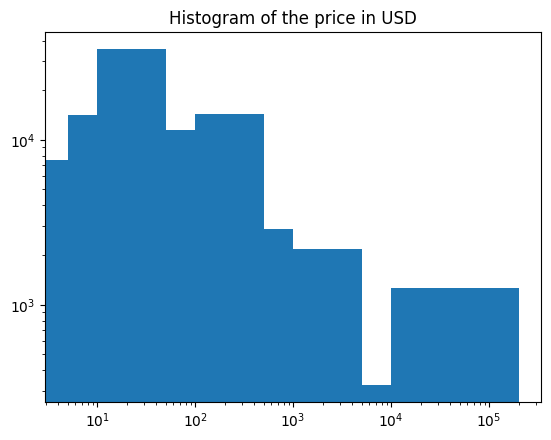

In [12]:
plt.hist(X_dataframe["price_usd"], bins = [0, 5, 10, 50, 100, 500, 1000, 5000, 10000, 200000])
plt.yscale("log")
plt.xscale("log")
plt.title("Histogram of the price in USD")
plt.show()


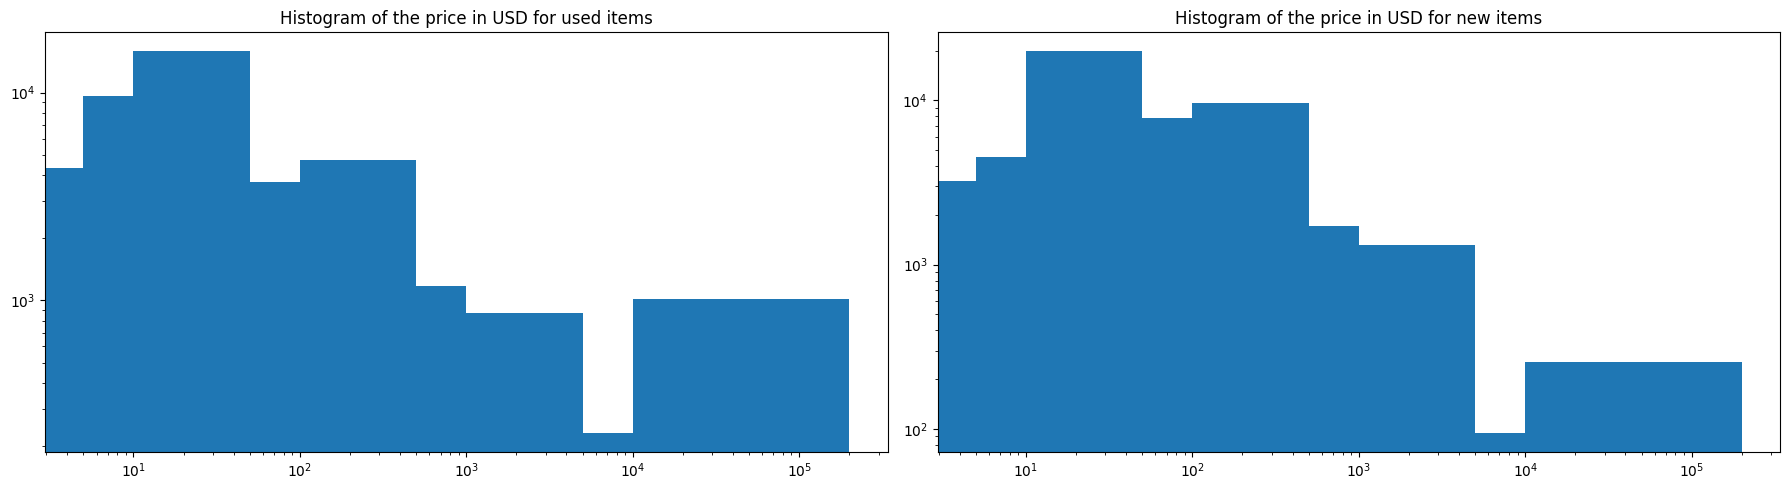

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].hist(
    X_dataframe.loc[X_dataframe["used"] == 1]["price_usd"],
        bins=[0, 5, 10, 50, 100, 500, 1000, 5000, 10000, 200000],
)
ax[0].set_title("Histogram of the price in USD for used items")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[1].hist(X_dataframe.loc[X_dataframe["used"] == 0]["price_usd"], bins = [0, 5, 10, 50, 100, 500, 1000, 5000, 10000, 200000])
ax[1].set_title("Histogram of the price in USD for new items")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
plt.tight_layout()

In [14]:
X_dataframe["price_usd"].apply(lambda x: np.log1p(x)).describe()

count    90000.000000
mean         3.652825
std          1.743481
min          0.089231
25%          2.397895
50%          3.359603
75%          4.498574
max         19.324549
Name: price_usd, dtype: float64

In [15]:
pearson_corr = X_dataframe[["used", "price_usd"]].corr(method="pearson")
spearman_corr = X_dataframe[["used", "price_usd"]].corr(method="spearman")
kendall_corr = X_dataframe[["used", "price_usd"]].corr(method="kendall")
print("Pearson correlation: ", pearson_corr)
print("Spearman correlation: ", spearman_corr)
print("Kendall correlation: ", kendall_corr)

Pearson correlation:                 used  price_usd
used       1.000000   0.001271
price_usd  0.001271   1.000000
Spearman correlation:                 used  price_usd
used       1.000000  -0.202263
price_usd -0.202263   1.000000
Kendall correlation:                 used  price_usd
used       1.000000  -0.165745
price_usd -0.165745   1.000000


The spearman and the keandall correlation show a relationship in that shows, slightly, that the newer the item, the higher the price.

However, in the histogram the used items seems to have more concentration in the high prices than the new ones